# Firo forensics

Description: Examining the 50%+1 attack on Firo in Jan 2021

Contact: firo-forensics@f32x.com

Support: `aCRUhBHi5WXS9Prq3HbXQkTG7TfHtfUDBx` (Firo)

## Import Libraries

In [1]:
import os as os
import pandas as pd
import matplotlib.pyplot as plt
import isthmuslib as isli
import numpy as np
import requests as requests

## Misc

In [2]:
pd.set_option('display.max_rows', None)
firo_red = (155/256, 28/256, 46/256)
firo_red_array = np.array([firo_red])
firo_gray = (244/256, 244/256, 244/256)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Import data

In [4]:
datapath = os.path.join('..', 'data')
active_blocks = pd.read_csv(os.path.join(datapath, 'firo_active_chain.csv'), delimiter=';')
active_blocks.rename(columns=lambda x: x.strip(), inplace=True)
abandoned_blocks = pd.read_csv(os.path.join(datapath, 'firo_abandoned.csv'), delimiter=';')
abandoned_blocks.rename(columns=lambda x: x.strip(), inplace=True)

Pull out attack blocks

In [5]:
attack_blocks = active_blocks[active_blocks['height'].isin(abandoned_blocks['height'])]

## Nonce visualizations

### Baseline nonce distribution
Looking at nonces from all blocks, it appears that 4 nonce search strategies are in use:
+ Start at 0 and iterate upwards (evidenced by the peak at 0 sloping down to 1e9)
+ Start at the halfway point and iterate upwards (evidenced by the smaller sawtooth at 2.15e9, see blue line)
+ Start at the upper range and iterate downwards (evidenced by the mirrored sawtooth at the upper limit)
+ Sample randomly over the entire range (the baseline signal throughout the range)

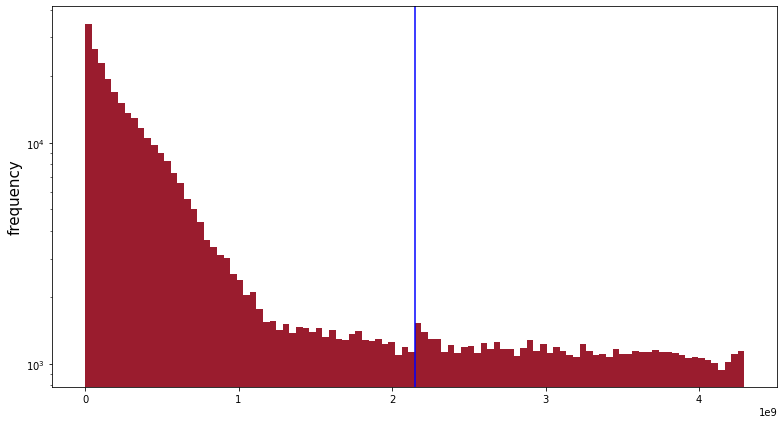

In [6]:
f = isli.hist(active_blocks['nonce'], yscale='log', bins=100, color=firo_red)
plt.axvline(x=max(active_blocks['nonce'])/2, color='blue');

### Attack block nonce distribution
It appears that the attacker was using software that employs the (dominant) strategy of starting at 0 and iterating upwards, as shown below

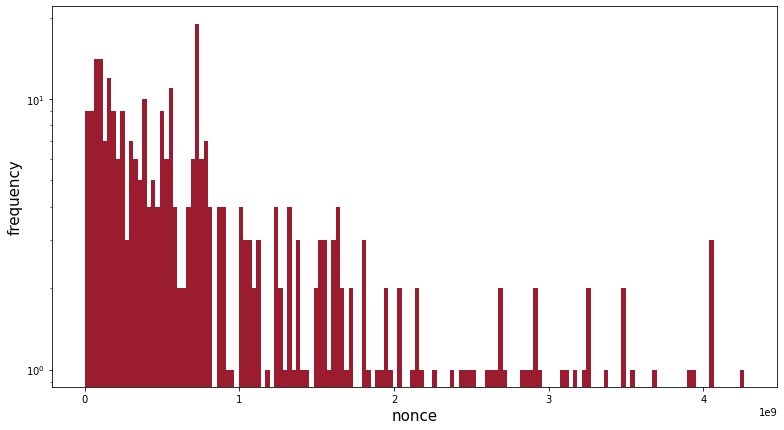

In [7]:
isli.hist(attack_blocks['nonce'], yscale='log', xlabel = 'nonce', color=firo_red);

### Side question - has the nonce search strategy changed over time?
Yes! A few observations:
+ Between heights 7,500 (red line) and 21,000 (lime line) the dominant strategy appears to be a uniform search over *only* the bottom half of the nonce range. I don't think I have observed this in any other cryptocurrency.
+ Between heights 21,000 (lime line) and 120,000 (yellow line) the search was extended to cover the entire nonce range (uniformly).
+ While the strategy of iterating upwards from low nonces has always been present to some extent, it really picked up as the dominant strategy around height 120,000 (yellow line) onwards. (You can also see the subtle trace of the middle-upwards strategy).

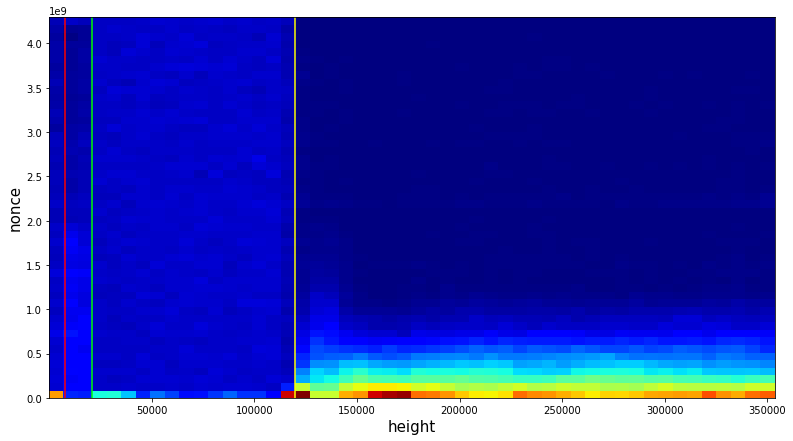

In [8]:
f = isli.hist2d(active_blocks['height'], active_blocks['nonce'], xlabel='height', ylabel='nonce', cmap='jet')
plt.axvline(x=7_500, color='red')
plt.axvline(x=21_000, color='lime')
plt.axvline(x=120_000, color='yellow');

## Which blocks did the attacker mine?

The attacker always mined with address `aMmjZpVtThPBV9nSihfw6ryPEQYrx7PTbq` and included the string `anon` in the coinbase transaction.

This next cell will serially query a blockchain explorer for info about the blocks in the range that the miner was online. It is disabled by default to avoid unnecessary pings, set `collect_block_info = True` to activate.

### Approach 1: Collect or insert data based on attacker address

See summary information in output cell

In [9]:
collect_block_info = False
earliest_block = 338403
latest_block = 338760
others_heights = list()

if collect_block_info:
    for h in range(earliest_block, latest_block):
        r = requests.get("https://www.coinexplorer.net/FIRO/block/" + str(h))
        if 'aMmjZpVtThPBV9nSihfw6ryPEQYrx7PTbq' not in r.text:
            others_heights.append(h)
else:
    # Skip the data collection and insert the result
    others_heights = [338720, 338750, 338753, 338756, 338759]
    
attacker_activity_window = latest_block - earliest_block
others_count = len(others_heights)
attacker_count = attacker_activity_window - others_count
attacker_fraction = attacker_count / attacker_activity_window


print('\n*************************************')
print('*************************************\n')
print('The attacker was active during a ' + str(attacker_activity_window) + ' block window from ' + str(earliest_block) + ' to ' + str(latest_block))
print('\nDuring that time, they mined ' + str(round(attacker_fraction*10000)/100) + '% of blocks ('+str(attacker_count)+ ' of ' + str(attacker_activity_window) +')')
print('\nThe only blocks that they did not mine were: ')
print('     ' + str(others_heights))
print('\n*************************************')
print('*************************************')



*************************************
*************************************

The attacker was active during a 357 block window from 338403 to 338760

During that time, they mined 98.6% of blocks (352 of 357)

The only blocks that they did not mine were: 
     [338720, 338750, 338753, 338756, 338759]

*************************************
*************************************


### Approach 2: Collect or insert data based on coinbase metadata

The attacker's coinbases always end with `4616e6f6e` (`anon`), for example:
+ height 337396 [https://www.coinexplorer.net/api/v1/FIRO/transaction?txid=44c1f52eb7a8ef417941416f7102e42e1954620211894c01d9c9264279869b73](https://www.coinexplorer.net/api/v1/FIRO/transaction?txid=44c1f52eb7a8ef417941416f7102e42e1954620211894c01d9c9264279869b73)
+ height 338403 [https://www.coinexplorer.net/api/v1/FIRO/transaction?txid=ad466dfc1c2b6532c74cd6f8fee4983f7cfac4781ebe4946b97978bdc1fa2745](https://www.coinexplorer.net/api/v1/FIRO/transaction?txid=ad466dfc1c2b6532c74cd6f8fee4983f7cfac4781ebe4946b97978bdc1fa2745)

First, we define `check_coinbase_tag` to check for the `4616e6f6e`/`anon` fingerprint

In [10]:
def check_coinbase_tag(block_height):
    r = requests.get("https://www.coinexplorer.net/FIRO/block/" + str(block_height))
    if 'anon</code' in r.text:
        return True
    else:
        return False

**Loop over heights of interest to check if the blocks have said fingerprint**

In [11]:
collect_block_info = True
verbosity = 1
earliest_block = 338400
latest_block = 338405
others_heights = list()
attacker_heights = list()

if collect_block_info:
    for h in range(earliest_block, latest_block):
        has_tag = check_coinbase_tag(h)
        if has_tag:
            attacker_heights.append(h)
            
        if verbosity:
            print('Height: ' + str(h) + " // Coinbase includes attacker's tag? " + str(has_tag))
else:
    # Skip the data collection and insert the result
    pass

Height: 338400 // Coinbase includes attacker's tag? False
Height: 338401 // Coinbase includes attacker's tag? False
Height: 338402 // Coinbase includes attacker's tag? False
Height: 338403 // Coinbase includes attacker's tag? True
Height: 338404 // Coinbase includes attacker's tag? True


**Does block 337396 (from before the attack) have the coinbase tag fingerprint?**

In [12]:
check_coinbase_tag(337396)

True

## Cross-chain attack analysis
**Everything in this section must be prefaced with the caveat that block timestamps are entirely spoofable, so this could have been faked.**

One question I've been wondering - did the attacker win by:
+ 1) brute force, i.e. using the same technology as the other miners, but having 50%+1 of the hashrate
+ 2) mining superpowers, e.g. having an FPGA or FPGA that can mine at 100x the rate of other participants

In the case of #2, the miner could over the course of minutes retroactively produce a day's worth of blocks. If you were to do that, what would you put in the timestamp field?? A few possibilities come to mind:
+ uniform timestamps (e.g. exactly 300 s between each block)
+ match original timestamps from the original chain, or always stamp the attack blocks as being a few seconds ahead of the honest blocks
+ the actual timestamps (which, if you were using a 100x speedup, would look absurdly crowded. This might not even be possible if there are consensus rules around block timestamps and maximum allowed delta)

In reality see none of these speculated artifacts, where the data would look too uniform or too perfect. We see an organic trend which suggests to that the attacker did not take deliberate steps to falsify the timestamps. This means we can examine their block production schedule and thus make inferences about their hashrate. If this is true, then it appears they had roughly 51% to 55%(?) of the global hashrate at the time of the attack. (_to-do: estimate hashrate from block production rate_)

There does not appear to be any groups of blocks mined in a rapid succession that could only occur with extreme optimization. However this does not necessarily indicate that FPGAs/ASICs or extreme software optimization doesn't exist (we can't rule out that this attack was carried out by a single device).

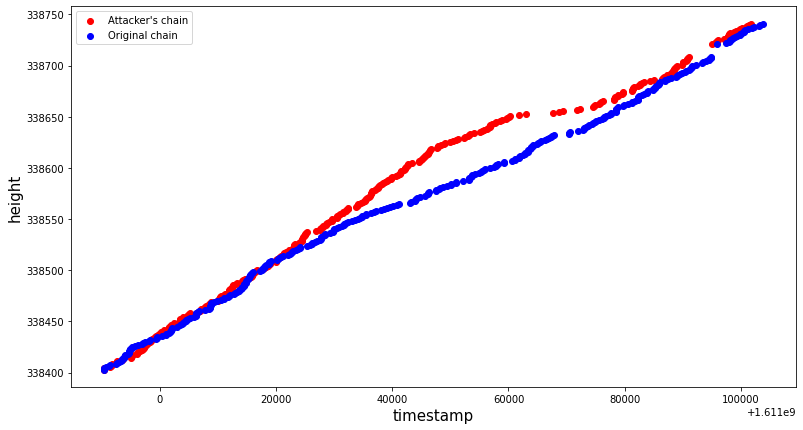

In [13]:
data_dictionary = [
    {'y': attack_blocks['height'],
     'x': attack_blocks['time'],
     'markercolor': 'r',
     'label': "Attacker's chain"},

    {'y': abandoned_blocks['height'],
        'x': abandoned_blocks['time'],
        'markercolor': 'b',
        'label': "Original chain"}
]

isli.scatterDictionary(data_dictionary, legend=True, xlabel='timestamp', ylabel='height');

For a moment, let's take a zoom out slightly on the above plot to the bigger picture (below) to see if the hashrate was from new equipment, or withdrawn from pools? 

Imagine that the attacker had no new equipment/hashrate, but controlled 50%+1 of the equipment that was already active. In this case, when the attack starts, the rate of block production would be cut in half (which would cause the slope of the abandoned blocks to be cut in half from the the slope observed outside of the attack). 

The above scenario is NOT what is observed in the data. The below plot shows that the block production schedule of the original (abandoned)  chain did not chage during the attack (between red lines). **This tells us that for the most part, the attacker had fresh equipment/hashrate that was not mining on the main chain immediately before or after the attack.**

(Note that around height 338550 there is in fact a small dip in the honest hashrate when the attacker's hashrate picks up some steam. This is a small delta and the statistical significance is unclear (it is not explored further here). If anything, it would mean that a small amount of organic hashrate joined the attacker partway through, however this would require back channel communication and coordination since the chain was not public at the time.)

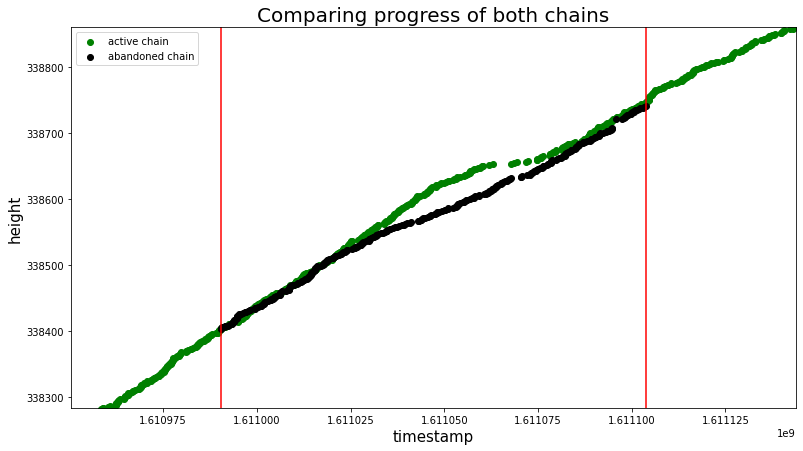

In [14]:
data_dictionary = [
    {'y': active_blocks['height'],
     'x': active_blocks['time'],
     'markercolor': 'g',
     'label': "active chain"},

    {'y': abandoned_blocks['height'],
        'x': abandoned_blocks['time'],
        'markercolor': 'k',
        'label': "abandoned chain"}
]

height_buffer = 120
time_buffer = 40000
isli.scatterDictionary(data_dictionary, legend=True, xlabel='timestamp', ylabel='height', 
                       xlim=(min(abandoned_blocks['time'])-time_buffer, max(abandoned_blocks['time'])+time_buffer), 
                       ylim=(min(abandoned_blocks['height'])-height_buffer, max(abandoned_blocks['height'])+height_buffer),
                       title='Comparing progress of both chains')
plt.axvline(x=min(abandoned_blocks['time']), color='r')
plt.axvline(x=max(abandoned_blocks['time']), color='r');

Let's look at the difference between the above two lines. In other words, when the honest chain was at height `h` how many blocks ahead or behind was the attacker. This will require a bit of data wrangling...

### Analysis data frame feature engineering

In [15]:
# initialize
t_values = list()
abandoned_height_values = list()
attacker_height_values = list()
analysis_df = pd.DataFrame()

for row_index in range(len(abandoned_blocks)):
    # Compare the chains
    t_abandoned = abandoned_blocks['time'][row_index]
    h_abandoned = abandoned_blocks['height'][row_index]
    attack_thus_far = attack_blocks[attack_blocks['time'] <= t_abandoned]
    if len(attack_thus_far) > 0:
        # Append to buffers
        h_attacker = max(attack_thus_far['height'])
        t_values.append(t_abandoned)
        abandoned_height_values.append(h_abandoned)
        attacker_height_values.append(h_attacker)
    
# Add to data frame
analysis_df['time'] = t_values
analysis_df['abandoned_height'] = abandoned_height_values
analysis_df['attacker_height'] = attacker_height_values

# Calculate difference
analysis_df['attacker_lead'] = analysis_df['attacker_height'] - analysis_df['abandoned_height']

### Attack progress visualization

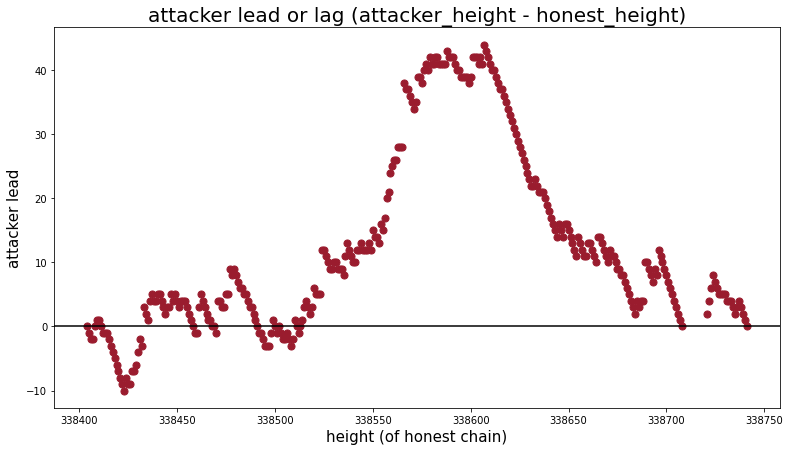

In [16]:
isli.scatter(analysis_df['abandoned_height'], analysis_df['attacker_lead'], xlabel='height (of honest chain)', ylabel='attacker lead', title='attacker lead or lag (attacker_height - honest_height)', markersize=50, markercolor=firo_red_array);
plt.axhline(y=0, color='k');

There's a few things to unpack with the above figure. 

For the first third of the attack, it appears that the attacker had about as much hashrate as the honest chain. In some cases the attacker fell behind by as much as 10 blocks but continued to persevere.

Around height 338510 it appears that the attacker's hashrate relative to the honest chain increased significantly, and they achieved a lead of 44 blocks at one point! 

Shortly after achieving the peak, the attacker's lead starts to wane, as their block production rate slowed relative to the honest chain.

Note / recall that although the reorgs stopped  at 338741, the attacker continued to be the dominant miner through block 338760 (the next 19 blocks ~ 1.5 hrs)